In [2]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display
from pathlib import Path

import poppy

# import zosapi
# from System import Enum,Int32,Double,Array

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
poppy_log.disabled = True

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

# plt_log = logging.getLogger('matplotlib')
# plt_log.setLevel('DEBUG')
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# plt_log.disabled = True

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

from apra_pop_models import fresnel_ote
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
from apra_pop_models.imshows import imshow1, imshow2, imshow3

pupil_diam = 6.5*u.m
wavelength_c = 650e-9*u.m

DEBUG:jaxlib.mlir._mlir_libs:Initializing MLIR with module: _site_initialize_0
DEBUG:jaxlib.mlir._mlir_libs:Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._site_initialize_0' from '/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/jaxlib/mlir/_mlir_libs/_site_initialize_0.so'>
DEBUG:jax._src.path:etils.epath was not found. Using pathlib for file I/O.


In [3]:
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


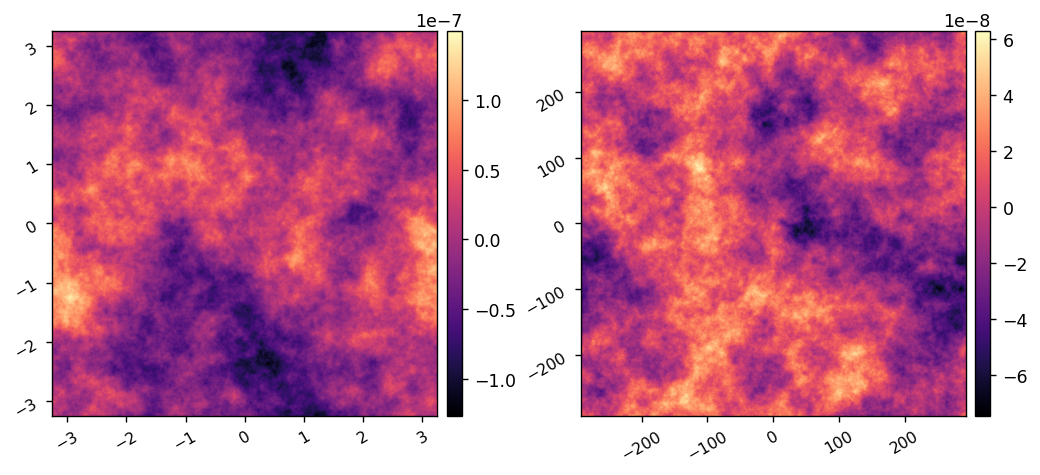

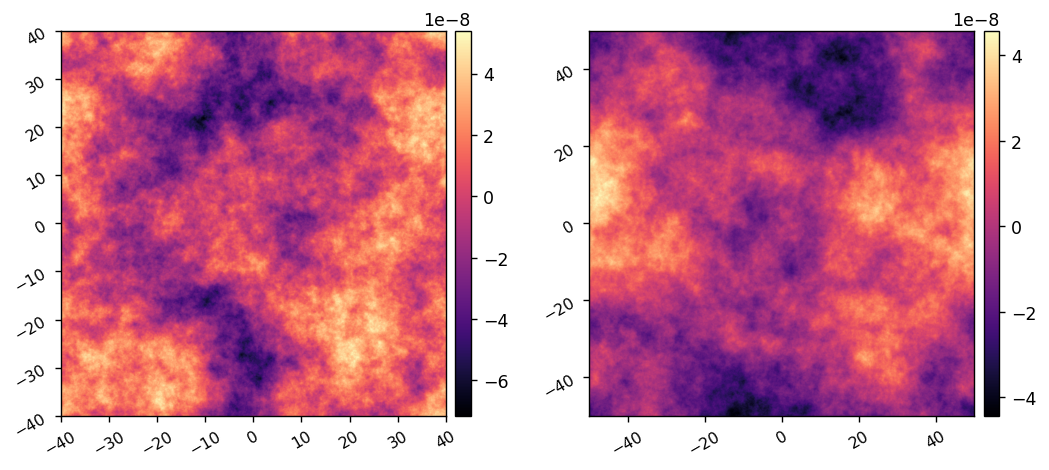

In [4]:
imshow2(tmodel.m1_opd.opd, tmodel.m2_opd.opd, 
        pxscl1=tmodel.m1_opd.pixelscale, pxscl2=tmodel.m2_opd.pixelscale.to(u.mm/u.pix))

imshow2(tmodel.m3_opd.opd, tmodel.m4_opd.opd, 
        pxscl1=tmodel.m3_opd.pixelscale.to(u.mm/u.pix), pxscl2=tmodel.m4_opd.pixelscale.to(u.mm/u.pix))

In [4]:
tmodel.npix = 1000
tmodel.oversample = 4

imshow1(tmodel.pupil_mask)

In [4]:
fnum = 35.3237
pupil_diam = 6.5*u.m
um_per_lamD = wavelength_c * fnum
print(um_per_lamD.to(u.mm))
psf_pixelscale_lamD = 1/tmodel.oversample
psf_pixelscale = psf_pixelscale_lamD / (wavelength_c/pupil_diam).decompose() 

0.022960405000000003 mm


Propagating wavelength 650.000 nm.
PSF calculated in 0.861s
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


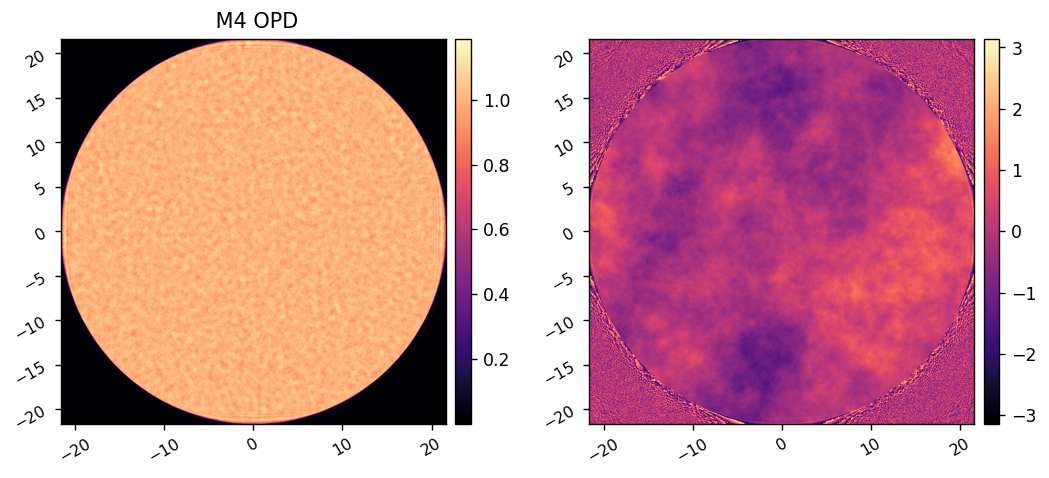

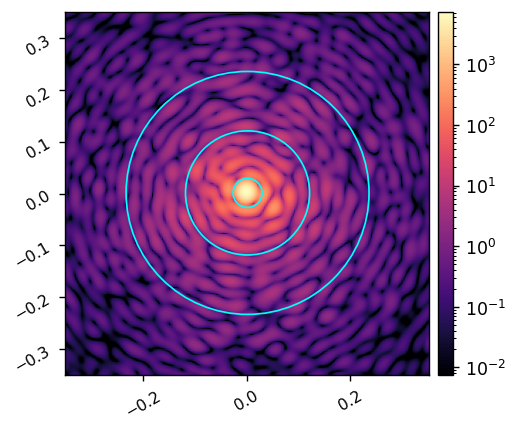

In [5]:
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()
tmodel.oversample = 8.192
tmodel.m4_corr = -11*u.mm
tmodel.defocus = 2.25*u.mm
tmodel.use_opds = True

wfs = tmodel.calc_wfs()
wf = wfs[-2]
imshow2(wf.amplitude, wf.phase, ''+wf.location[5:], 
        pxscl=wf.pixelscale.to(u.mm/u.pix), npix=tmodel.npix)

psf = wfs[-1].intensity
psf_pixelscale = wfs[-1].pixelscale.to_value(u.mm/u.pix)
imshow1(psf, pxscl=wfs[-1].pixelscale.to(u.mm/u.pix), npix=256,
        lognorm=True, vmin=xp.max(psf)/1e6,
        patches=[Circle((psf_pixelscale/2,psf_pixelscale/2), 1.22*um_per_lamD.to_value(u.mm), fill=False, color='cyan'),
                 Circle((psf_pixelscale/2,psf_pixelscale/2), 5.22*um_per_lamD.to_value(u.mm), fill=False, color='cyan'),
                 Circle((psf_pixelscale/2,psf_pixelscale/2), 10.22*um_per_lamD.to_value(u.mm), fill=False, color='cyan')])

In [24]:
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()
tmodel.oversample = 8.192
tmodel.m4_corr = -11*u.mm
tmodel.defocus = 2.25*u.mm

perfect_psf = xp.abs(tmodel.calc_wf())**2

tmodel.use_opds = True
ab_psf = xp.abs(tmodel.calc_wf())**2

psf_pixelscale = wfs[-1].pixelscale.to_value(u.mm/u.pix)
fig, ax = imshow2(perfect_psf, ab_psf,
                  pxscl=wfs[-1].pixelscale.to(u.mm/u.pix), npix=256,
                  cmap1='magma', cmap2='magma',
        lognorm=True, vmin1=xp.max(perfect_psf)/1e6, vmin2=xp.max(perfect_psf)/1e6,
        patches1=[Circle((psf_pixelscale/2,psf_pixelscale/2), 1.22*um_per_lamD.to_value(u.mm), fill=False, color='cyan'),
                  Circle((psf_pixelscale/2,psf_pixelscale/2), 5.22*um_per_lamD.to_value(u.mm), fill=False, color='lime'),
                  Circle((psf_pixelscale/2,psf_pixelscale/2), 10.22*um_per_lamD.to_value(u.mm), fill=False, color='red')],
        patches2=[Circle((psf_pixelscale/2,psf_pixelscale/2), 1.22*um_per_lamD.to_value(u.mm), fill=False, color='cyan', label='1.22$\lambda/D$'),
                  Circle((psf_pixelscale/2,psf_pixelscale/2), 5.22*um_per_lamD.to_value(u.mm), fill=False, color='lime', label='5.22$\lambda/D$'),
                  Circle((psf_pixelscale/2,psf_pixelscale/2), 10.22*um_per_lamD.to_value(u.mm), fill=False, color='red', label='10.22$\lambda/D$')],
        return_fig=True, display_fig=False)
fontsize = 16
ax[0].set_title('Perfect PSF', fontsize=20)
ax[1].set_title('Aberrated PSF', fontsize=20)
ax[0].set_ylabel('Y [mm]', fontsize=fontsize)
ax[0].set_xlabel('X [mm]', fontsize=fontsize)
ax[1].set_xlabel('X [mm]', fontsize=fontsize)
ax[1].legend(fontsize=14, loc='upper right')
display(fig)

In [22]:
!nvidia-smi

Wed Jun  5 17:07:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   35C    P0             63W /  300W |   42977MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Oversampling > 2x suggested for reliable results in Fresnel propagation.


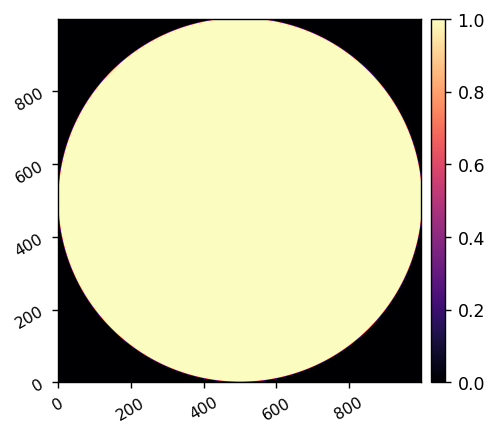

In [10]:
imshow1(tmodel.pupil_mask)

# Test beamwalk effects

In [29]:
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()
tmodel.m4_corr = -11*u.mm
tmodel.use_opds = True
tmodel.calc_pupil = True
amp, opd = tmodel.calc_wf()

fig, ax = imshow2(amp, opd, 'Nominal Exit Pupil Amplitude', 'Nominal Exit Pupil OPD', 
                  cmap1='plasma', cmap2='cividis', 
                  wspace=0.05,
                  return_fig=True, display_fig=False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
display(fig)

Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.


0.005881435897432141 pix 0.005881435897432141 pix
0.46489600000000786 pix 0.46489600000000786 pix


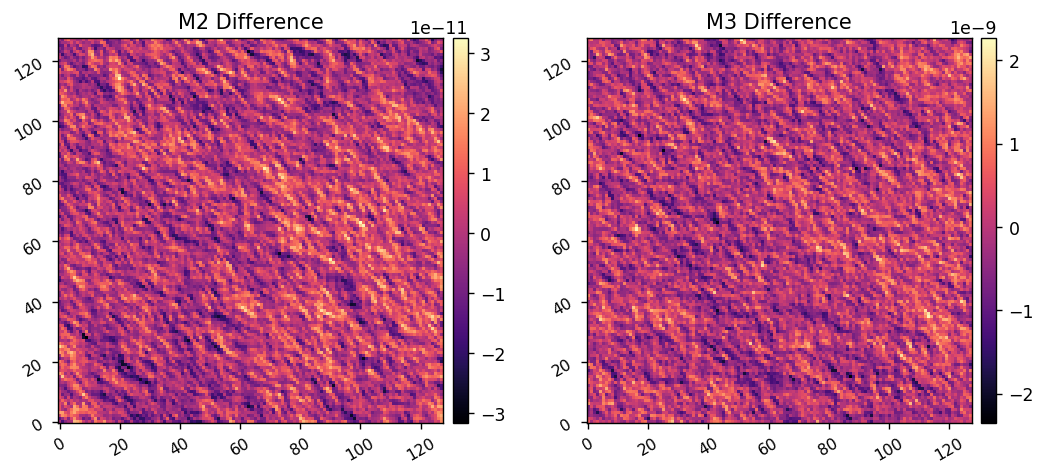

In [10]:
pointing = np.array([10, 10]) * u.mas
tmodel.init_opds()
tmodel.shift_surface_errors(pointing, quiet=False, plot=True)

In [27]:
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()
tmodel.m4_corr = -11*u.mm
tmodel.use_opds = True
tmodel.calc_pupil = True
amp, opd = tmodel.calc_wf()

In [10]:
pointing_vals = np.linspace(-25,25, 101)*u.mas
for i in range(len(pointing_vals)):
    pointing_x = pointing_vals[i]
    for j in range(len(pointing_vals)):
        pointing_y = pointing_vals[j]
        pointing = (pointing_x, pointing_y)

        tmodel.init_opds()
        tmodel.shift_surface_errors(pointing)
        amp, opd = tmodel.calc_wf()
        ote_data = xp.array([amp, opd])
        utils.save_fits(f'/npool/nvme/kianmilani/wfe-data/telescope_wfe_{pointing_x.value:.0f}mas_{pointing_y.value:.0f}mas.fits', ote_data, quiet=True)
    print('next x')
    

next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x
next x


In [8]:
tmodel.init_opds()

In [25]:
pointing_x = 10*u.mas
pointing_y = 10*u.mas 

m2_x_shift = np.abs(tmodel.m2_shift_per_mas) * pointing_x
m2_y_shift = np.abs(tmodel.m2_shift_per_mas) * pointing_y

m2_x_shift_pix = (m2_x_shift/tmodel.m2_opd.pixelscale).decompose()
m2_y_shift_pix = (m2_y_shift/tmodel.m2_opd.pixelscale).decompose()
print(m2_x_shift_pix, m2_y_shift_pix)

m3_x_shift = np.abs(tmodel.m3_shift_per_mas) * pointing_x
m3_y_shift = np.abs(tmodel.m3_shift_per_mas) * pointing_y

m3_x_shift_pix = (m3_x_shift/tmodel.m3_opd.pixelscale).decompose()
m3_y_shift_pix = (m3_y_shift/tmodel.m3_opd.pixelscale).decompose()
print(m3_x_shift_pix, m3_y_shift_pix)

m2_shifted_opd = _scipy.ndimage.shift(tmodel.m2_opd.opd, (m2_y_shift_pix.value, m2_x_shift_pix.value))
m2_diff = tmodel.m2_opd.opd - m2_shifted_opd
# imshow1(diff, npix=128)



m3_shifted_opd = _scipy.ndimage.shift(tmodel.m3_opd.opd, (m3_y_shift_pix.value, m3_x_shift_pix.value))
m3_diff = tmodel.m3_opd.opd - m3_shifted_opd
fig,ax = imshow2(m2_diff, m3_diff, npix1=128, npix2=128,  
                 pxscl1=tmodel.m2_opd.pixelscale.to(u.mm/u.pix), pxscl2=tmodel.m3_opd.pixelscale.to(u.mm/u.pix),
                 return_fig=True, display_fig=False)

fontsize = 20
ax[0].set_title('M2 WFE Difference\nwith Beamwalk', fontsize=fontsize)
ax[1].set_title('M3 WFE Difference\nwith Beamwalk', fontsize=fontsize)
fontsize = 16
ax[0].set_ylabel('Y [mm]', fontsize=fontsize)
ax[0].set_xlabel('X [mm]', fontsize=fontsize)
ax[1].set_xlabel('X [mm]', fontsize=fontsize)
display(fig)

tmodel.m2_opd.opd = m2_shifted_opd
tmodel.m3_opd.opd = m3_shifted_opd

0.005881435897432141 pix 0.005881435897432141 pix
0.46489600000000786 pix 0.46489600000000786 pix


In [20]:
5*u.mm / tmodel.m2_opd.pixelscale.to(u.mm/u.pix), 5*u.mm / tmodel.m3_opd.pixelscale.to(u.mm/u.pix)

(<Quantity 35.00854701 pix>, <Quantity 256. pix>)

M2 shift in physical units:  0.0008399999999994634 mm 0.0008399999999994634 mm
M3 shift in physical units:  0.009080000000000154 mm 0.009080000000000154 mm
M2 shift in pixels:  0.005881435897432141 pix 0.005881435897432141 pix
M3 shift in pixels:  0.46489600000000786 pix 0.46489600000000786 pix


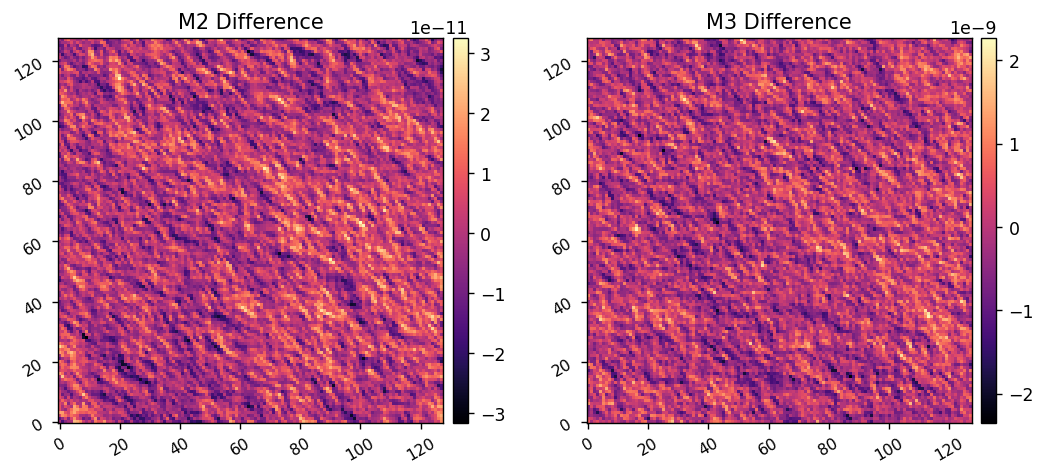

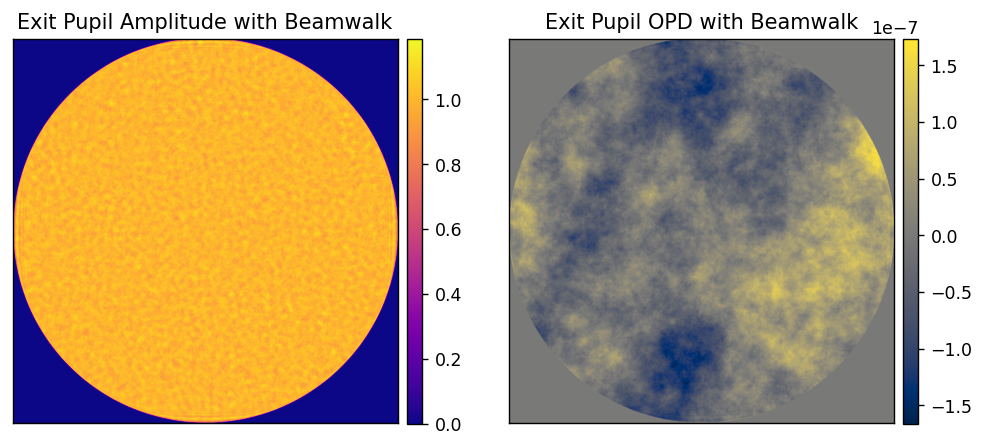

In [30]:
pointing = np.array([10, 10]) * u.mas
tmodel.init_opds()
tmodel.shift_surface_errors(pointing, quiet=False, plot=True)

amp2, opd2 = tmodel.calc_wf()
fig, ax = imshow2(amp, opd, 'Exit Pupil Amplitude with Beamwalk', 'Exit Pupil OPD with Beamwalk', 
                  cmap1='plasma', cmap2='cividis', 
                  wspace=0.05,
                  return_fig=True, display_fig=False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
display(fig)

In [33]:
# imshow2(amp-amp2, opd-opd2, npix=256)
amp_diff = amp-amp2
fig, ax = imshow3(amp, amp2, amp_diff,
                  'Nominal Exit Pupil Amplitude', 'Exit Pupil Amplitude\nwith 50mas Beamwalk', 'Difference in Amplitude', 
                  cmap1='plasma', cmap2='plasma', 
                  wspace=0.2,
                  return_fig=True, display_fig=False)
ax[0].set_title('Nominal Exit\nPupil Amplitude', fontsize=20)
ax[1].set_title('Exit Pupil Amplitude with\n50mas Beamwalk', fontsize=20)
ax[2].set_title('Difference in Amplitude', fontsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
display(fig)

opd_diff = opd-opd2

fig,ax = imshow2(amp_diff, opd_diff, 
                 cmap1='plasma', cmap2='viridis',
                 return_fig=True, display_fig=False)

fontsize = 20
ax[0].set_title('Exit Pupil Amplitude Difference\nwith Beamwalk', fontsize=fontsize)
ax[1].set_title('Exit Pupil WFE Difference\nwith Beamwalk', fontsize=fontsize)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

display(fig)


In [43]:
ote_data = xp.array([amp2, opd2])
utils.save_fits('../wfe-data/telescope_wfe_50mas_50mas.fits', ote_data)

Saved data to:  ../wfe-data/telescope_wfe_50mas_50mas.fits


In [11]:
def oap_fl(ROC, OAD):
    VFL = ROC/2
    DEL = OAD**2 / (2*ROC)
    A   = VFL - DEL
    EFL = np.sqrt(A**2 + OAD**2)
    return EFL
    
ROC = 3.653217939049540E+004*u.mm
OAD = 4000*u.mm

ROC = -3.666455045389474E+003*u.mm
OAD = 375*u.mm

ROC = 2.319999498167194E+003*u.mm
OAD = 275*u.mm


6500.0 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e02349d0>


DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x7fa7dbdde610> <matplotlib.colors.Normalize object at 0x7fa7dbdde610>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e01b28d0>
DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x7fa7dbdde610> <matplotlib.colors.Normalize object at 0x7fa7dbdde610>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e01b28d0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e059c8d0>


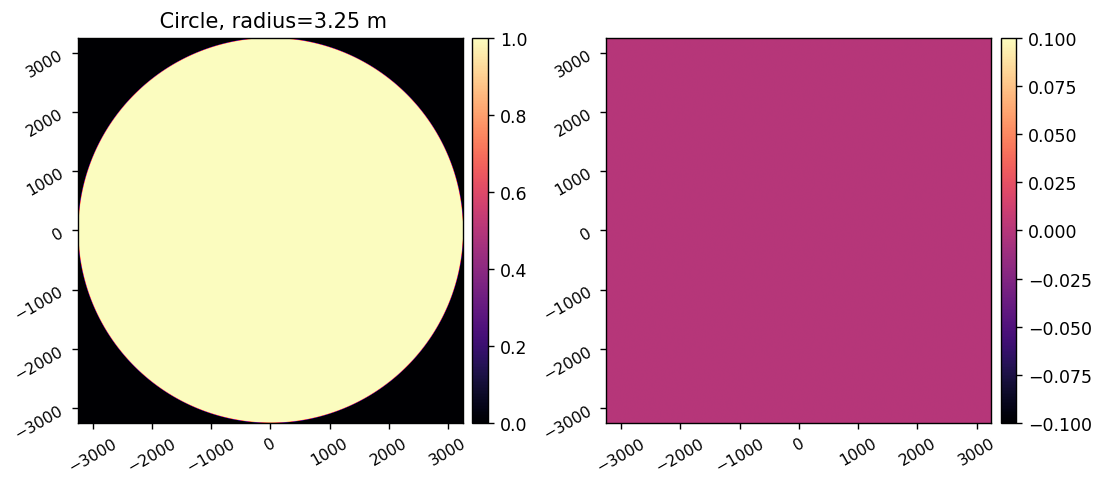

6500.0 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e07c8190>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e065ad90>


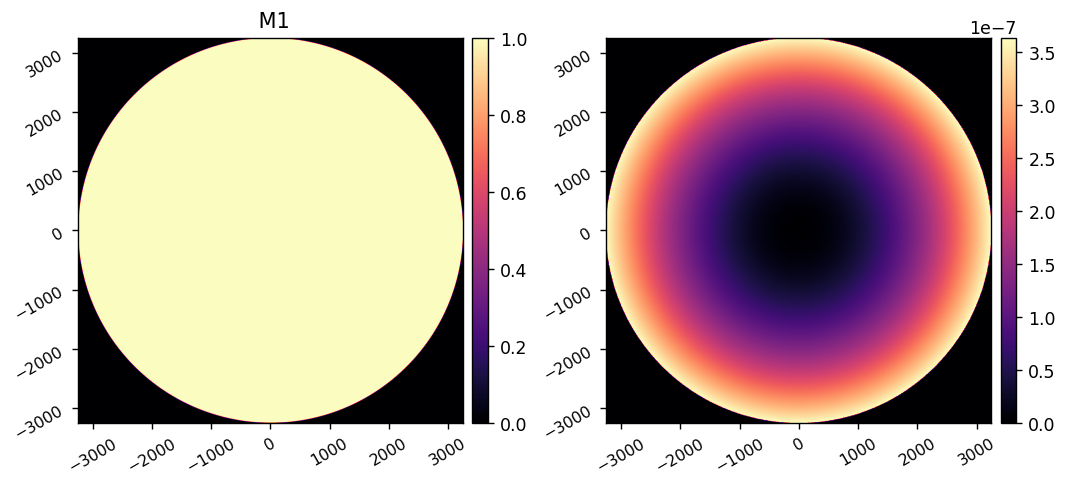

581.8631311979512 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7dbcb2410>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7e025f850>


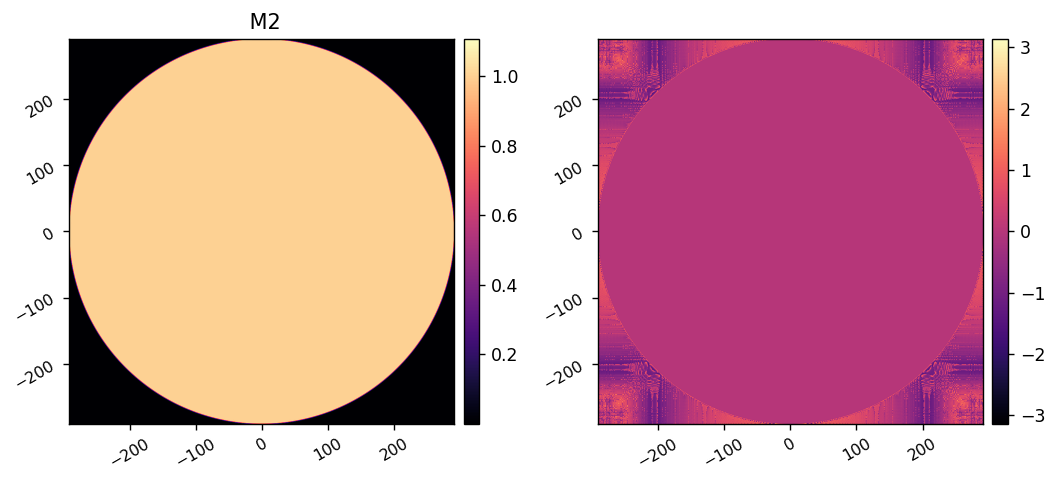

79.19731426730466 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7db895e50>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7dbcd2410>


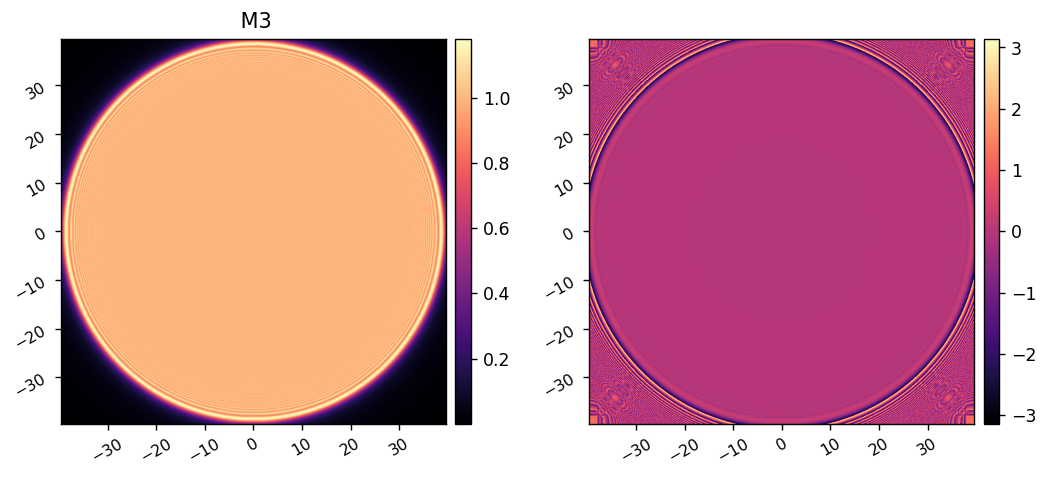

43.24253534602564 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7dbcc0150>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7dbcc3290>


5.6186281537187375 mm
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.LogLocator object at 0x7fa7dbc3bdd0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fa7dbabb390>
DEBUG:matplotlib.ticker:vmin 0.00018051885381526497 vmax 196.33180162982788
DEBUG:matplotlib.ticker:ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])
DEBUG:matplotlib.ticker:vmin 0.00018051885381526497 vmax 196.33180162982788
DEBUG:matplotlib.ticker:ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8

In [64]:
for i,wf in enumerate(wfs):
    if i<(len(wfs)-1):
        npix = tmodel.npix 
        lognorm = False
    else:
        npix = 256
        lognorm = True
    # print(wf.z_w0, wf.z)
    diam = wf.pixelscale.to(u.mm/u.pix) * tmodel.npix *u.pix
    print(diam)
    imshow2(wf.amplitude, wf.phase, ''+wf.location[5:], 
            pxscl=wf.pixelscale.to(u.mm/u.pix), npix=npix, lognorm1=lognorm)

In [208]:
m2_footprint = 2*291.3362*u.mm
m3_footprint = 2*39.192*u.mm
m4_footprint = 21.5849*2
print(m2_footprint)
print(m3_footprint)
print(m4_footprint)

582.6724 mm
78.384 mm
43.1698
